In [1]:
import pandas as pd
import numpy as np
from pydataset import data

import wrangle
import matplotlib.pyplot as plt

# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import explained_variance_score


import warnings
warnings.filterwarnings("ignore")


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## 1. Select a dataset with a continuous target variable.

In [3]:
# check the different datasets available in pydatasets
# data()

In [4]:
# select and load my dataset
df = data('EmplUK')

In [5]:
# quick look at data
df.head()

,firm,year,sector,emp,wage,capital,output
1,1,1977,7,5.041,13.1516,0.5894,95.707199
2,1,1978,7,5.600,12.3018,0.6318,97.356903
3,1,1979,7,5.015,12.8395,0.6771,99.608299
4,1,1980,7,4.715,13.8039,0.6171,100.550100
5,1,1981,7,4.093,14.2897,0.5076,99.558098


In [6]:
# read docs of data
data('EmplUK', show_doc =True)

EmplUK

PyDataset Documentation (adopted from R Documentation. The displayed examples are in R)

## Employment and Wages in the United Kingdom

### Description

An unbalanced panel of 140 observations from 1976 to 1984

_total number of observations_ : 1031

_observation_ : firms

_country_ : United Kingdom

### Usage

    data(EmplUK)

### Format

A data frame containing :

firm

firm index

year

year

sector

the sector of activity

emp

employment

wage

wages

capital

capital

output

output

### Source

Arellano, M. and Bond, S. (1991), Some Tests of Specification for Panel Data:
Monte Carlo Evidence and an Application to Employment Equations, _The Review
of Economic Studies_, vol. **58**(2), 1991, pp.227–297.




In [7]:
# info about df
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1031 entries, 1 to 1031
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   firm     1031 non-null   int64  
 1   year     1031 non-null   int64  
 2   sector   1031 non-null   int64  
 3   emp      1031 non-null   float64
 4   wage     1031 non-null   float64
 5   capital  1031 non-null   float64
 6   output   1031 non-null   float64
dtypes: float64(4), int64(3)
memory usage: 64.4 KB


In [8]:
# split df
train, validate, test = wrangle.split_data(df)

In [9]:
train.head()

,firm,year,sector,emp,wage,capital,output
722,104,1977,7,1.388,17.587999,0.5916,95.820999
565,81,1980,4,0.790,21.758801,0.1477,100.000000
629,90,1981,2,10.806,25.315001,6.7985,91.750000
890,125,1977,8,0.451,19.853500,0.1110,117.339200
976,134,1983,8,13.349,18.491100,1.2235,94.671402


> predicting wage so that is our target variable

In [10]:
# assign X and y variables
X_train = train.drop(columns = ['wage'])
X_validate = validate.drop(columns = ['wage'])
X_test = test.drop(columns = ['wage'])

y_train = train[['wage']]
y_validate = validate[['wage']]
y_test = test[['wage']]

In [11]:
# scale the predictors 
scaler, X_train_scaled, X_validate_scaled, X_test_scaled= wrangle.Min_Max_scaler(X_train, X_validate, X_test)

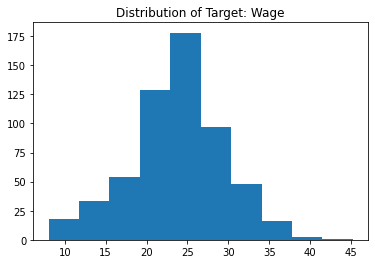

In [12]:
# how do we determine distribution of target?
plt.hist(y_train)
plt.title('Distribution of Target: Wage')
plt.show()

## Takeaways:

- Distribution is pretty much normal

### Use skbest and rfe to see which are the top 4 features

In [13]:
wrangle.select_kbest(X_train_scaled, y_train, 4)

Index(['firm', 'sector', 'emp', 'capital'], dtype='object')

In [14]:
wrangle.rfe(X_train_scaled, y_train, 4)

Index(['sector', 'emp', 'capital', 'output'], dtype='object')

<AxesSubplot:>

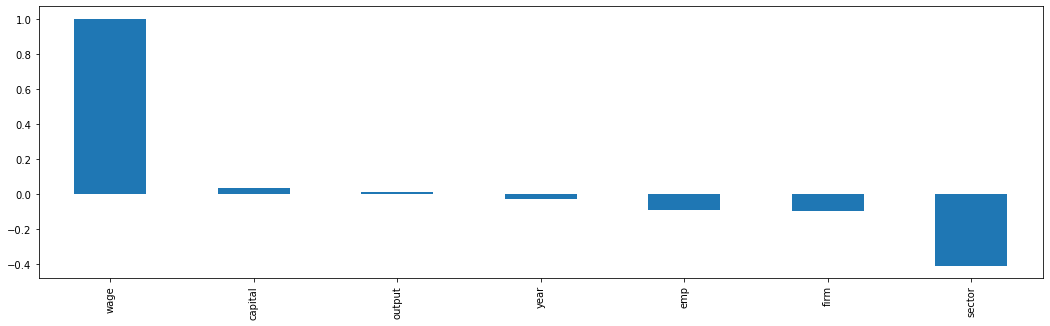

In [15]:
# correlation of features with the target variable

train.corr().wage.sort_values(ascending=False).plot(kind='bar', figsize=(18,5))


###  Based on rfe and correlation, we will go with the following features:
- sector
- capital
- emp


In [16]:
features = ['sector', 'emp', 'capital']

In [17]:
# 1. Predict wage_pred_mean
wage_pred_mean = y_train.wage.mean()
y_train['wage_pred_mean'] = wage_pred_mean
y_validate['wage_pred_mean'] = wage_pred_mean

# 2. compute wage_pred_median
wage_pred_median = y_train.wage.median()
y_train['wage_pred_median'] = wage_pred_median
y_validate['wage_pred_median'] = wage_pred_median

# # 3. RMSE of wage_pred_mean
rmse_train = mean_squared_error(y_train.wage, y_train.wage_pred_mean) ** 0.5
rmse_validate = mean_squared_error(y_validate.wage, y_validate.wage_pred_mean) ** 0.5

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))


# # 4. RMSE of wage_pred_median
rmse_train = mean_squared_error(y_train.wage, y_train.wage_pred_median) ** .5
rmse_validate = mean_squared_error(y_validate.wage, y_validate.wage_pred_median) ** .5
print('-----------')
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  5.7 
Validate/Out-of-Sample:  5.79
-----------
RMSE using Median
Train/In-Sample:  5.7 
Validate/Out-of-Sample:  5.8


### Since using the mean, results in a smaller drop between RMSE for the train and validate sets, we will proceed with using the mean wage as the baseline

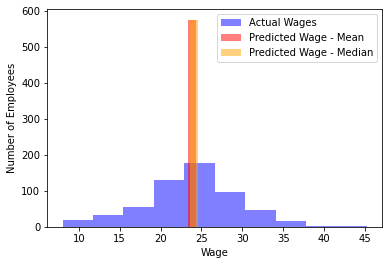

In [18]:
# plot to visualize actual vs predicted
plt.hist(y_train.wage, color='blue', alpha=.5, label="Actual Wages")
plt.hist(y_train.wage_pred_mean, bins=1, color='red', alpha=.5, rwidth=100, label="Predicted Wage - Mean")
plt.hist(y_train.wage_pred_median, bins=1, color='orange', alpha=.5, rwidth=100, label="Predicted Wage - Median")
plt.xlabel("Wage")
plt.ylabel("Number of Employees")
plt.legend()
plt.show()

In [19]:
metric_df = pd.DataFrame(data=[{
    'model': 'mean_baseline',
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.wage, y_validate.wage_pred_mean)}])

In [20]:
metric_df

,model,rmse_validate,r^2_validate
0,mean_baseline,5.797031,-2.220446e-16


In [21]:
y_train.head()

,wage,wage_pred_mean,wage_pred_median
722,17.587999,23.851947,24.04815
565,21.758801,23.851947,24.04815
629,25.315001,23.851947,24.04815
890,19.853500,23.851947,24.04815
976,18.491100,23.851947,24.04815


### LinearRegression (OLS)
- Fit the model using X_train_scaled and the labels from y_train.

- Predict final grade for students in training sample using our model (lm).

- Evaluate using RMSE

- Repeat predictions and evaluation for validation.

- Compare RMSE train vs. validation. Overfitting?

- Add to metric df

In [22]:
# create the model object
# 
# make the thing
# 
lm = LinearRegression()

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
# 
# fit the thing
# 
lm.fit(X_train[features], y_train.wage)

# predict train
# 
# use the thing!
# 
y_train['wage_pred_lm'] = lm.predict(X_train[features])

# evaluate: rmse
rmse_train = mean_squared_error(y_train.wage, y_train.wage_pred_lm) ** (1/2)
# predict validate
y_validate['wage_pred_lm'] = lm.predict(X_validate[features])

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.wage, y_validate.wage_pred_lm) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  5.091112825053391 
Validation/Out-of-Sample:  5.30923201100839


In [23]:
metric_df = metric_df.append(
    {
    'model': 'OLS lm 1',
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.wage, y_validate.wage_pred_lm)}, ignore_index=True)

In [24]:
metric_df

,model,rmse_validate,r^2_validate
0,mean_baseline,5.797031,-2.220446e-16
1,OLS lm 1,5.309232,1.565701e-01


### LassoLars
- Fit the model using X_train_scaled and the labels from y_train.

- Predict final grade for students in training sample using our model (lars).

- Evaluate using RMSE

- Repeat predictions and evaluation for validation.

- Compare RMSE train vs. validation. Overfitting?

- Add to metric df

In [25]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series!
lars.fit(X_train[features], y_train.wage)

# predict train
y_train['wage_pred_lars'] = lars.predict(X_train[features])

# evaluate: rmse
rmse_train = mean_squared_error(y_train.wage, y_train.wage_pred_lars) ** 0.5

# predict validate
y_validate['wage_pred_lars'] = lars.predict(X_validate[features])

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.wage, y_validate.wage_pred_lars) ** 0.5

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  5.698897591032835 
Validation/Out-of-Sample:  5.7857842900693885


In [26]:
metric_df = metric_df.append(
    {
    'model': 'LassoLars alpha 1',
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.wage, y_validate.wage_pred_lars)}, ignore_index=True)

In [27]:
metric_df

,model,rmse_validate,r^2_validate
0,mean_baseline,5.797031,-2.220446e-16
1,OLS lm 1,5.309232,1.565701e-01
2,LassoLars alpha 1,5.785784,-2.220446e-16


### TweedieRegressor (GLM)¶
- Fit the model using X_train_scaled and the labels from y_train.

- Predict final grade for students in training sample using our model (glm).

- Evaluate using RMSE

- Repeat predictions and evaluation for validation.

- Compare RMSE train vs. validation. Overfitting?

- Add to metric df

In [28]:
# create the model object
glm = TweedieRegressor(power=0, alpha=1)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 

glm.fit(X_train[features], y_train.wage)

# predict train
y_train['wage_pred_glm'] = glm.predict(X_train[features])

# evaluate: rmse
rmse_train = mean_squared_error(y_train.wage, y_train.wage_pred_glm) ** 0.5


# predict validate
y_validate['wage_pred_glm'] = glm.predict(X_validate[features])

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.wage, y_validate.wage_pred_glm) ** 0.5


print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  5.099444997748806 
Validation/Out-of-Sample:  5.302625067758969


In [29]:
metric_df = metric_df.append(
    {
    'model': 'Tweedie GLM Model power 1',
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.wage, y_validate.wage_pred_glm)}, ignore_index=True)

In [30]:
metric_df

,model,rmse_validate,r^2_validate
0,mean_baseline,5.797031,-2.220446e-16
1,OLS lm 1,5.309232,1.565701e-01
2,LassoLars alpha 1,5.785784,-2.220446e-16
3,Tweedie GLM Model power 1,5.302625,1.586809e-01


### Polynomial Regression
- Using sklearn.preprocessing.PolynommialFeatures() + sklearn.linear_model.LinearRegression()

- Create the new features, based on value indicated for degree for train, validate & test.

- Fit the Linear Regression model

- Predict using the transformed (squared or cubed, e.g.) features

- Evaluate using RMSE

- Repeat predictions and evaluation for validation.

- Compare RMSE train vs. validation. Overfitting?

- Add to metric df

In [60]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train[features])

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate[features])
X_test_degree2 = pf.transform(X_test[features])

### Linear Regression 

In [61]:
# create the model object
# 
# make the thing
# 
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
# 
# fit the thing
# 
lm2.fit(X_train_degree2, y_train.wage)

LinearRegression(normalize=True)

In [54]:
# predict train
# 
# use the thing!
# 
y_train['wage_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.wage, y_train.wage_pred_lm2) ** (1/2)
# predict validate
y_validate['wage_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.wage, y_validate.wage_pred_lm2) ** (1/2)

print("RMSE for PolynomialRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for PolynomialRegression
Training/In-Sample:  5.037155509817979 
Validation/Out-of-Sample:  5.254855957116693


In [55]:
metric_df = metric_df.append(
    {
    'model': 'PolyReg Model',
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.wage, y_validate.wage_pred_lm2)}, ignore_index=True)

In [56]:
metric_df

,model,rmse_validate,r^2_validate
0,mean_baseline,5.797031,-2.220446e-16
1,OLS lm 1,5.309232,1.565701e-01
2,LassoLars alpha 1,5.785784,-2.220446e-16
3,Tweedie GLM Model power 1,5.302625,1.586809e-01
4,PolyReg Model,5.254856,1.737639e-01
5,PolyReg Model,5.254856,1.737639e-01


### Evaluate
#### Plotting Actual vs. Predicted Values

In [36]:
y_validate.head()

,wage,wage_pred_mean,wage_pred_median,wage_pred_lm,wage_pred_lars,wage_pred_glm,wage_pred_lm2
416,23.1630,23.851947,24.04815,20.770514,23.851947,21.172880,21.234132
650,22.6926,23.851947,24.04815,22.062282,23.851947,22.051659,22.937019
889,27.0973,23.851947,24.04815,26.836692,23.851947,26.501729,26.504566
77,24.0345,23.851947,24.04815,25.945265,23.851947,25.715583,25.460895
88,26.0042,23.851947,24.04815,27.527459,23.851947,27.095451,27.714245


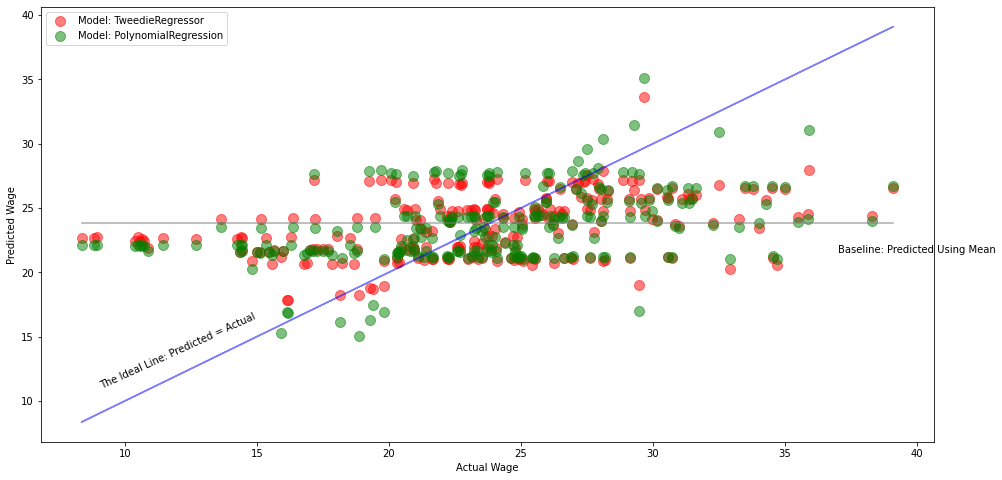

In [38]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.wage, y_validate.wage_pred_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predicted Using Mean", (37, 21.5))
plt.plot(y_validate.wage, y_validate.wage, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (9, 11), rotation=24.5)

plt.scatter(y_validate.wage, y_validate.wage_pred_glm, 
            alpha=.5, color="red", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.wage, y_validate.wage_pred_lm2, 
            alpha=.5, color="green", s=100, label="Model: PolynomialRegression")
plt.legend()
plt.xlabel("Actual Wage")
plt.ylabel("Predicted Wage")

plt.show()

> The Polynomial Regression Model is our best performing model with the lowest rmse and highest R squared

### Residual Plots: Plotting the Errors in Predictions



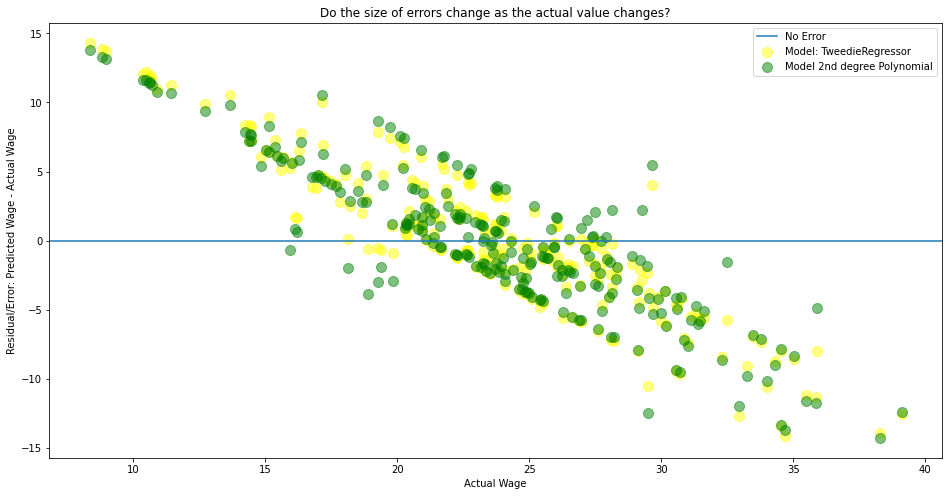

In [41]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.axhline(label="No Error")
# plt.scatter(y_validate.wage, y_validate.wage_pred_lm - y_validate.wage, 
#             alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.wage, y_validate.wage_pred_glm - y_validate.wage, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.wage, y_validate.wage_pred_lm2 - y_validate.wage, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Wage")
plt.ylabel("Residual/Error: Predicted Wage - Actual Wage")
plt.title("Do the size of errors change as the actual value changes?")

plt.show()

## Takeaways

- There is a pattern in our residuals which means the model missed something 
- With the limited correlation between predictors and target and the small number of observations, it is unlikely this model can be improved further. However, some tuning of hyperparameters may help further reduce rmse and increase R squared.

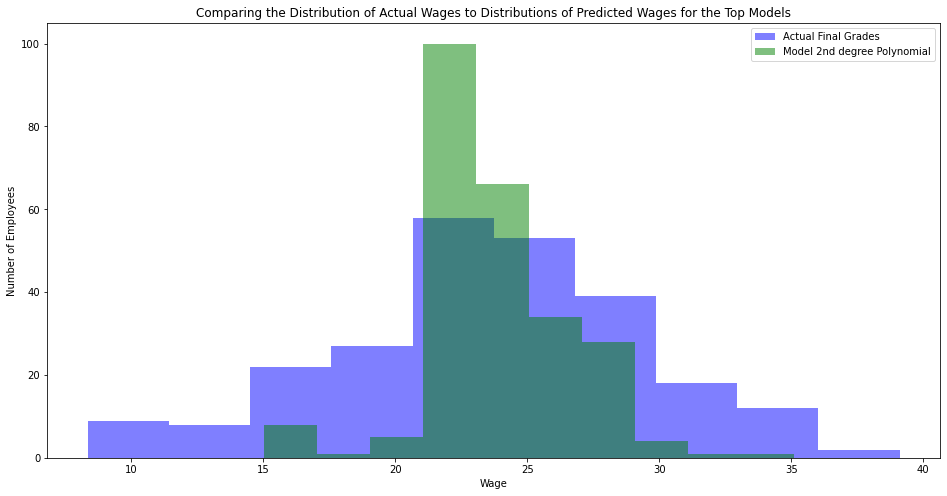

In [43]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_validate.wage, color='blue', alpha=.5, label="Actual Final Grades")
# plt.hist(y_validate.wage_pred_glm, color='red', alpha=.4, label="Model: TweedieRegressor")
plt.hist(y_validate.wage_pred_lm2, color='green', alpha=.5, label="Model 2nd degree Polynomial")
plt.xlabel("Wage")
plt.ylabel("Number of Employees")
plt.title("Comparing the Distribution of Actual Wages to Distributions of Predicted Wages for the Top Models")
plt.legend()
plt.show()


In [44]:
lm2

LinearRegression(normalize=True)

In [49]:
features

['sector', 'emp', 'capital']

In [62]:
# predict on test
y_test['wage_pred_lm2'] = lm2.predict(X_test_degree2)


In [64]:
# evaluate: rmse
rmse_test = mean_squared_error(y_test.wage, y_test.wage_pred_lm2) ** 0.5
print("RMSE for Model using PolynomialRegression\nOut-of-Sample Performance: ", rmse_test)

RMSE for Model using PolynomialRegression
Out-of-Sample Performance:  4.841229939258224
